In [2]:
import pandas as pd
from scipy.special import binom
from tqdm import tqdm
from itertools import combinations
from pathlib import Path
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


def rec_dd():
    return defaultdict(rec_dd)


In [3]:
benchmark_path = Path(
    "/home/gabrielathenes/Documents/study/HILARy/data_with_scripts/benchmark_on_partis_dataset"
)
hilary_full = "hilary-full-1-2-0"
hilary_cdr3 = "hilary-cdr3-1-2-0"


In [4]:
def pairwise_evaluation(df, partition, ground_truth="simulations"):
    TP = 0
    P = binom(df.groupby([ground_truth]).size(), 2).sum()
    TP_FP = binom(df.groupby([partition]).size(), 2).sum()
    for _, family in tqdm(df.groupby([ground_truth]), disable=True):
        for r1, r2 in combinations(family[partition], 2):
            if r1 == r2:
                TP += 1
    if TP_FP == 0:
        return 0.0, 1.0
    elif P == 0:
        return None, None
    return (
        TP / P,
        TP / TP_FP,
    )  # sensitivity, precision

def entropy(dfGrouped):
    fs = dfGrouped.size()
    fs = fs / sum(fs)
    return sum(fs * np.log2(fs))


def variation_of_info(df, result):
    VI = (
        entropy(df.groupby(["simulations"]))
        + entropy(df.groupby([result]))
        - 2 * entropy(df.groupby([result, "simulations"]))
    )
    return VI


In [5]:
metric_dict=rec_dd()
for seed in [0, 1, 2]:
    prec_list=[]
    sens_list=[]
    var_list=[]
    for freq in ["0.01","0.05","0.10","0.20","0.30"]:
        dataframe=pd.DataFrame()
        for model in ["simulations"]+[f"crude_{str(each/100)}" for each in [12,18,24]]+[hilary_full, hilary_cdr3]:
            if model == "simulations":
                df = pd.read_csv(
                [
                    each
                    for each in (
                        benchmark_path
                        / Path(
                            f"seed-{seed}/scratch-mute-freq-{freq}/{model}/single_chain/"
                        )
                    ).glob(f"*igh.tsv")
                ][0],
                sep="\t",
                index_col="sequence_id",
            )
                dataframe[model]=df["clone_id"]

            elif model.startswith("hilary"):

                if model.startswith("hilary-cdr3"):
                    df = pd.read_csv(
                        benchmark_path
                        / Path(
                            f"seed-{seed}/scratch-mute-freq-{freq}/{model}/single_chain/inferred_cdr3_based_igh.tsv"
                        ),
                        index_col="sequence_id",
                        sep="\t",
                    )
                    dataframe[model] = df["cdr3_based_family"]

                else:
                    df = pd.read_csv(
                        benchmark_path
                        / Path(
                            f"seed-{seed}/scratch-mute-freq-{freq}/{model}/single_chain/inferred_full_method_igh.tsv"
                        ),
                        index_col="sequence_id",
                        sep="\t",
                    )
                    dataframe[model] = df["family"]

            else:
                df = pd.read_csv(
                    benchmark_path
                    / Path(
                        f"seed-{seed}/scratch-mute-freq-{freq}/{model}/single_chain/inferred_crude_method_igh.tsv"
                    ),
                    sep="\t",
                    index_col="sequence_id",
                )
                dataframe[model] = df["crude_method_family"]

            sensitivity,precision=pairwise_evaluation(dataframe,model)
            varinfo = variation_of_info(dataframe,model)
            metric_dict[model]["precision"][freq][seed]=precision
            metric_dict[model]["sensitivity"][freq][seed]=sensitivity
            metric_dict[model]["variation_of_info"][freq][seed]=varinfo


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colormap2 = cm.get_cmap("gist_earth", 12)


/tmp/ipykernel_2040852/2353547508.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap2 = cm.get_cmap("gist_earth", 12)


crude_0.12
precision
sensitivity
variation_of_info
crude_0.18
precision
sensitivity
variation_of_info
crude_0.24
precision
sensitivity
variation_of_info
hilary-full-1-2-0
precision
sensitivity
variation_of_info
hilary-cdr3-1-2-0
precision
sensitivity
variation_of_info


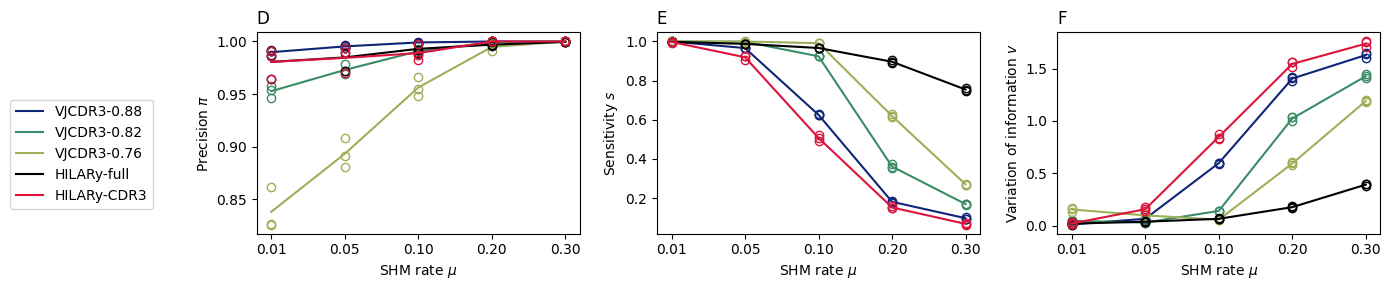

In [8]:
ls = [0.01,0.05,0.10,0.20,0.30]
fig = plt.figure(figsize=(14, 3))
ax1 = fig.add_subplot(131)
ax1.set_ylabel(r"Precision $\pi$")
ax1.set_xlabel(r"SHM rate $\mu$")
ax2 = fig.add_subplot(132)
ax2.set_ylabel("Sensitivity $s$")
ax2.set_xlabel(r"SHM rate $\mu$")
ax3 = fig.add_subplot(133)
ax3.set_ylabel(r"Variation of information $v$")
ax3.set_xlabel(r"SHM rate $\mu$")

colors = {
    f"crude_{str(each/100)}": colormap2((each - 9) / 24)
    for i, each in enumerate([12, 18, 24])
}
colors[hilary_full] = "k"
colors[hilary_cdr3] = "crimson"
labels = {
    f"crude_{str(each/100)}": f"VJCDR3-{str(round(1 - each / 100, 2))}"
    for each in [12, 18, 24]
}
axes=[ax1,ax2,ax3]

for model in colors:
    if model.startswith("crude"):
        label = f"{labels[model]}"
    if model==hilary_full:
        label="HILARy-full"
    if model == hilary_cdr3:
        label = "HILARy-CDR3"
    print(model)
    for i,metric in enumerate(metric_dict[model]):
        print(metric)
        for freq in metric_dict[model][metric]:
            y=list(metric_dict[model][metric][freq].values())
            x=[freq]*len(y)
            axes[i].plot(
                x, y, "o", fillstyle="none", color=colors[model],
            )
        lengths=[]
        averages=[]
        for freq in metric_dict[model][metric]:
            lengths.append(freq)
            averages.append(np.mean(list(metric_dict[model][metric][freq].values())))
        axes[i].plot(
            lengths,
            averages,
            color=colors[model],
            label=label)
        axes[i].set_title(["D","E","F"][i],loc='left'),


ax1.legend(bbox_to_anchor=(-2.6, -0.1, 2.3, 0.8))

plt.tight_layout()
# fig.savefig('new_figures/figure4.pdf',bbox_inches='tight',dpi=1000)
plt.savefig(
    "/home/gabrielathenes/Dropbox/Natanael_lineages_inference/revisions_2024_01_26/figures/figureSI_VJCDR3_MT.png",
)
plt.show()
